Import Libraries

In [1]:
# # Install the latest JAXlib version.
# !pip install --upgrade -q pip jax jaxlib
# # Install Flax at head:
# # !pip install --upgrade -q git+https://github.com/google/flax.git
# !pip install flax
# # !pip install flax==0.5.1
# # !pip install evojax
# !pip install optax

In [2]:
import jax
import optax
import time
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from scipy import array, power, diag, cos, sin, pi
# config.enable_omnistaging() # Linen requires enabling omnistaging
# from evojax.util import get_params_format_fn

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINNs Network

In [3]:
node = 8
class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    self.layers = [nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      x, t = inputs[:,0:1], inputs[:,1:2]
      
      def get_u(x, t):
        u = jnp.hstack([x, t])
        for i, lyr in enumerate(self.layers):
          u = lyr(u)
        return u

      u = get_u(x, t)

      # obtain u_t
      def get_u_t(get_u, x, t):
        u_t = jacfwd(get_u, 1)(x, t)
        return u_t
      u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
      u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
      #obtain u_x
      def get_u_x(get_u, x, t):
        u_x = jacfwd(get_u)(x, t)
        return u_x
      u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
      u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
      #obtain u_xx    
      def get_u_xx(get_u, x, t):
        u_xx = hessian(get_u)(x,t)
        return u_xx
      u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
      u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)

      action = jnp.hstack([u,u_x, u_xx, u_t])   
      return action

In [4]:
model = PINNs()
# params = model.init(random.PRNGKey(0), jnp.zeros([2,1]))

In [5]:
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,2]) # Dummy input
params = model.init(key2, a) # Initialization call
# jax.tree_map(lambda a: a.shape, params) # Checking output shapes
# model.apply(params, a)
# num_params, format_params_fn = get_params_format_fn(params)
params

FrozenDict({
    params: {
        layers_0: {
            kernel: DeviceArray([[-5.7519700e-02,  6.1773393e-02,  5.7582674e-04,
                           2.2985055e-01, -6.2718205e-02, -2.7909055e-01,
                          -5.6730941e-02,  6.7408484e-01],
                         [ 1.7127079e-01, -3.5103104e-01,  2.1496566e-01,
                           4.5700255e-01,  5.8078241e-01, -5.4574656e-01,
                           1.9077779e-01,  7.1804821e-01]], dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        layers_2: {
            kernel: DeviceArray([[-0.45770732, -0.27446413, -0.35641724, -0.49977297,
                           0.02891943,  0.45564798,  0.4506553 , -0.04619164],
                         [-0.41307658, -0.53576845,  0.02062074,  0.58753616,
                          -0.44982034, -0.2511399 , -0.20213905, -0.27392817],
                         [ 0.5340896 , -0.59196264, -0.26925746, -0.17218477,
   

Functions

In [6]:
def f_ic(x):
    return jnp.exp(-(k*x)**2)

Hyper parameters and data 

In [7]:

vis = 0.001

# initial condition
k = 2

# spatial domain
x_l, x_u = -2.0, 2.0

# time domain: 0 - t_T
t_T = 2.0

# fitness evaluation time
t_fitness = 0 

In [8]:
sim = pd.read_csv('three.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
batch_X = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values


Loss Function

In [9]:
def make_mse_func(input):
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(input):
        # [u,u_x, u_xx, u_xxx, u_t]
        x = input[:,0:1].reshape(-1,1)
        t = input[:,1:2].reshape(-1,1)
        prediction = model.apply(params, input)
        u, u_x, u_xx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4]
    # ground truth

        t_u = f_ic(x) 
        _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
        # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
        ic_mse = jnp.sum(jnp.square((t_u-u)*_ic))/jnp.sum(_ic)
        # PDE (physics laws) 
        pde = u_t + u*u_x - vis*u_xx


        # exclude BC points
        _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
        pde = pde*_pde
        pde_mse = jnp.sum(jnp.square(pde))/jnp.sum(_pde)
        pde_mse = pde_mse 
        loss = pde_mse + ic_mse
        return loss
    return squared_error(input)
  return jax.jit(mse) # And finally we jit the result.

# Get the sampled loss
loss = make_mse_func(batch_X)

Weights Update

In [10]:

def update(params, opt_state):
    start = time.time()  
    loss_value, grad = jax.value_and_grad(loss)(params)
    end = time.time()
    global t_fitness
    t_fitness = t_fitness + (end-start)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value
update = jit(update)

Optimizer

In [11]:
alpha = 0.1
optimizer = optax.sgd(learning_rate=alpha)
# optimizer = optax.adam(learning_rate=alpha) # Choose the method
opt_state = optimizer.init(params)
loss_grad_fn = jax.value_and_grad(loss)

Training 

In [12]:
max_iters = 250000
loss_ls = []
t_training = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.process_time()
    params, opt_state, loss_value = update(params, opt_state)
    end = time.process_time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    # update
    runtime += (end-start)
    train_iters += 1    

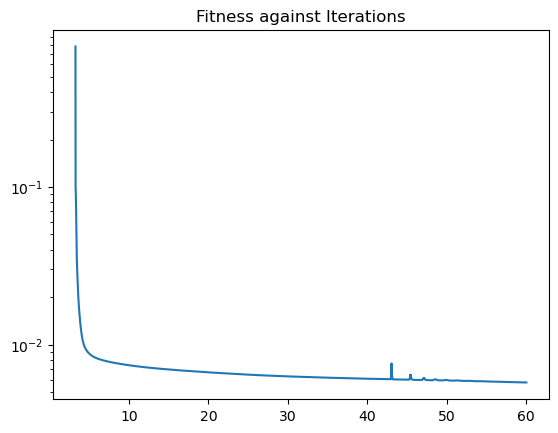

In [13]:
import numpy as np
training_ls = np.cumsum(t_training)

plt.plot(training_ls, loss_ls); plt.yscale('log');
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [14]:
import pandas as pd

df = pd.DataFrame({'Training Time': training_ls, 'Loss': loss_ls})
#df.to_csv('nonlinear_sgd_%d.csv'%(seed), index=False)
df
#writer = pd.ExcelWriter('nonlinear_sgd.xlsx', engine='xlsxwriter')
#df.to_excel(writer, sheet_name='cma', index=False)
#writer.save()

,Training Time,Loss
0,3.278871,0.78003645
1,3.279741,0.35836554
2,3.280364,0.20928521
3,3.280844,0.15117382
4,3.281446,0.12791964
...,...,...
67986,59.997136,0.0057470915
67987,59.997977,0.005747077
67988,59.998831,0.005747064
67989,59.999664,0.005747052


In [15]:
hello = PINNs()
prediction = hello.apply(params, batch_X)
u = prediction[:,0:1]

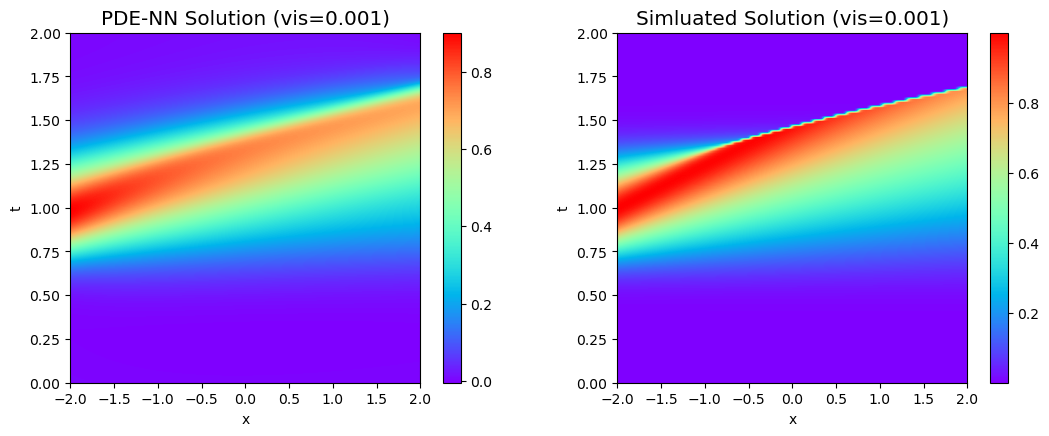

In [16]:
fig = plt.figure(figsize=(20, 10))
u_viz = (u.reshape(201, 129)).T 
ext = [x_l, x_u, 0 ,t_T]     # plot boundary 
ax1 = fig.add_subplot(2,3,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=2); 
plt.colorbar(mesh) 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('PDE-NN Solution (vis=%s)' %(vis), fontsize='x-large'); 


u_true = (y_train.reshape(201, 129)).T 
ext = [x_l, x_u, 0 ,t_T]     # plot boundary 
ax2 = fig.add_subplot(2,3,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=2); 
plt.colorbar(mesh2); 
plt.xlabel('x'); plt.ylabel('t'); 
plt.title('Simluated Solution (vis=%s)' %(vis), fontsize='x-large'); 
# plt.savefig('solutionplot2/(params_size=%s_popn=%s_init_std=%s).png' %(params_size, popn, init_std))


In [17]:
np.mean((u_viz - u_true)**2)

DeviceArray(0.0076465, dtype=float32)

In [18]:
np.save('nonlinear_sgd_60s', (u_viz, u_true))